In [79]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [80]:
!pip install torchmetrics
from torchmetrics import Accuracy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [81]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt

In [82]:
os.chdir("/content/drive/MyDrive/MovieRSystem")

In [83]:
dataset = pd.read_csv("FeatureExtracted/dataset.csv")
ratings_train = pd.read_csv("CleanedData/ratings_train.csv")
ratings_test = pd.read_csv("CleanedData/ratings_test.csv")

## Content-Based Recommendation System - Pytorch

In [84]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [85]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

### Make Dataset For Train

There are 671 users

In [86]:
len_users = len(ratings_train['userId'].unique())
print(len_users)

671


2830 movies

In [87]:
len_dataset = len(dataset)
print(len_dataset)

2830


We need to save the id for later recommendation

In [88]:
dataset

,budget,id,runtime,revenue,vote_average,vote_count,CastsRank,NumLeadActors,HasTop50Actors,NumCrews,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,60000000,949,170.0,187436818.0,7.7,1886.0,14175,3,0,71,...,0,0,0,0,0,0,0,1,0,0
1,58000000,710,130.0,352194034.0,6.6,1194.0,5703,3,1,46,...,0,0,0,0,0,0,0,1,0,0
2,98000000,1408,119.0,10017322.0,5.7,137.0,3771,0,0,16,...,0,0,0,0,0,0,0,0,0,0
3,52000000,524,178.0,116112375.0,7.8,1343.0,6447,0,0,10,...,0,0,0,0,0,0,0,0,0,0
4,16500000,4584,136.0,135000000.0,7.2,364.0,4515,2,1,8,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2825,0,80831,121.0,0.0,6.5,2.0,1105,0,0,4,...,0,0,0,0,0,0,0,0,0,0
2826,0,3104,92.0,0.0,5.9,33.0,1129,0,0,11,...,0,1,0,0,0,1,0,0,0,0
2827,0,64197,97.0,0.0,6.0,5.0,399,0,0,4,...,0,0,0,0,1,0,0,0,0,0
2828,0,98604,91.0,0.0,4.6,6.0,1982,0,0,4,...,0,0,0,0,1,0,0,0,0,0


In [89]:
indexToId = dict(zip(dataset.index, dataset['id']))
idToIndex = dict(zip(dataset['id'], dataset.index))

In [90]:
indexToId[0]

949

In [91]:
dataset.drop(columns = ['id'], inplace = True)

In [92]:
from sklearn import preprocessing

In [93]:
dataset = preprocessing.scale(dataset)

In [94]:
len_features = dataset.shape[1]

Test Transfrom Metadata Movies Dataframe to Tensor

In [95]:
movies_tensor = torch.tensor(dataset, requires_grad= False)

Test Transform Ratings to Sparse Tensor

In [96]:
ratings_train["movieId"] = ratings_train["movieId"].apply(lambda x: idToIndex[x])

In [97]:
ratings_test["movieId"] = ratings_test["movieId"].apply(lambda x: idToIndex[x])

In [98]:
len(ratings_train['userId'].unique()) == len(ratings_test['userId'].unique())

False

In [99]:
ratings_train["userId"] = ratings_train["userId"].apply(lambda x: x - 1)
ratings_test["userId"] = ratings_test["userId"].apply(lambda x: x - 1)

In [100]:
ratings_tensor = torch.sparse_coo_tensor([ratings_train['userId'], ratings_train['movieId']], ratings_train['rating'], (len_users, len_dataset))

All works normally!

Now we will put all those codes into one block

Rating larger than 4.0 will be assigned by **2** else **1**. 2 and 1 because we want to avoid the misunderstanding of library with 0 for the unrated one

In [101]:
ratings_train['rating'] = ratings_train['rating'].apply(lambda x: 2 if x >= 4 else 1)
ratings_test['rating'] = ratings_test['rating'].apply(lambda x: 2 if x >= 4 else 1)

Convert dataset to Tensor data structure

In [102]:
movies_tensor = torch.tensor(dataset, requires_grad= False)
movies_tensor = torch.cat((movies_tensor, torch.ones(len_dataset, 1, dtype = torch.float64)), axis = 1)
ratings_train_tensor = torch.sparse_coo_tensor([ratings_train['userId'],\
                                                     ratings_train['movieId']],\
                                                     ratings_train['rating'], (len_users, len_dataset))
ratings_test_tensor = torch.sparse_coo_tensor([ratings_test['userId'],\
                                                     ratings_test['movieId']],\
                                                     ratings_test['rating'], (len_users, len_dataset))

ratings_train_tensor = ratings_train_tensor.to_dense()
ratings_test_tensor = ratings_test_tensor.to_dense()

In [103]:
from torch.autograd import Variable

In [104]:
ratings_train_tensor[0][474]

tensor(0)

### Train

We proposed a Regression Model for predicting Ratings

To predict the rate from user model $U$ and movies profiles $M$:

$U$ * $M^\top$ = $\hat{R}$ 

$L = BCE(\hat{R}, R)$ for all movies that have rated 

Find the partial derivatives for matrix $U$ : $ \dfrac{\partial L}{\partial U} $

Update $U$ based on $ \dfrac{\partial L}{\partial U} $

To calculate derivatives, we use **Autograd** of ***Pytorch***

In [105]:
"""
Autograd example
"""
# ratings_pred = torch.matmul(torch.cat((U, b), axis = 1), movies_tensor.T)
# mask = ratings_train_tensor.bool()
# nonzero_pred = F.sigmoid(ratings_pred.masked_select(mask))
# nonzero_train = ratings_train_tensor.masked_select(mask)
# loss = criterion(nonzero_pred, nonzero_train)
# loss.backward()

'\nAutograd example\n'

In [106]:
U = Variable(torch.randn(len_users, len_features, dtype = torch.float64), requires_grad=True)
b = Variable(torch.randn(len_users, 1, dtype = torch.float64), requires_grad=True)

Here we use BCELoss (**Binary Cross Entropy Loss**) for classification 0 and 1

Metrics use is `accuracy`.

In [107]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam([U], lr = 0.005)
optimizer.add_param_group({'params': b, "lr": 0.005, "weight_decay": 0})

In [108]:
from tqdm.notebook import tqdm

In [109]:
bestU = None
bestb = None
maxAcc = 0.0

First try 3001 loop without regulization, lr = 0.005

In [110]:
EPOCH = 3001
a = Accuracy()
trainLoss = []
testLoss = []
testEp = []
trainAcc = []
testAcc =[]
for ep in tqdm(range(EPOCH)):
    optimizer.zero_grad()
    ratings_pred = torch.matmul(torch.cat((U, b), axis = 1), movies_tensor.T)
    mask = ratings_train_tensor.bool()
    nonzero_pred = F.sigmoid(ratings_pred.masked_select(mask))
    nonzero_train = ratings_train_tensor.masked_select(mask)
    nonzero_train = nonzero_train - 1
    loss = criterion(nonzero_pred, nonzero_train.double())
    accuracy = a(nonzero_pred, nonzero_train.int())
    loss.backward()
    optimizer.step()

    trainLoss.append(loss.item())
    trainAcc.append(accuracy.item())
    if ep % 10 == 0:
      mask = ratings_test_tensor.bool()
      nonzero_pred = F.sigmoid(ratings_pred.masked_select(mask))
      nonzero_test = ratings_test_tensor.masked_select(mask)
      nonzero_test = nonzero_test - 1
      loss_test = criterion(nonzero_pred, nonzero_test.double())
      accuracy_test = a(nonzero_pred, nonzero_test.int())

      testEp.append(ep)
      testLoss.append(loss_test.item())
      testAcc.append(accuracy_test.item())
      
      if maxAcc < accuracy_test:
        bestU = U
        bestb = b
        maxAcc = accuracy_test
      print(f'Epoch: {ep}. Train Loss: {loss}. Train Acc: {accuracy}. Valid Loss: {loss_test}. Valid Acc: {accuracy_test}.')


  0%|          | 0/3001 [00:00<?, ?it/s]

Epoch: 0. Train Loss: 2.6021032840791753. Train Acc: 0.5026102066040039. Valid Loss: 2.632373077345012. Valid Acc: 0.5015540719032288.
Epoch: 10. Train Loss: 2.3964616955627855. Train Acc: 0.5116044878959656. Valid Loss: 2.5082133083826244. Valid Acc: 0.5038283467292786.
Epoch: 20. Train Loss: 2.2067153002474775. Train Acc: 0.5228945016860962. Valid Loss: 2.3908052068681886. Valid Acc: 0.5047380924224854.
Epoch: 30. Train Loss: 2.038653748385524. Train Acc: 0.5344990491867065. Valid Loss: 2.2853512019140725. Valid Acc: 0.5070881843566895.
Epoch: 40. Train Loss: 1.8874746493934837. Train Acc: 0.5468897223472595. Valid Loss: 2.201229526207343. Valid Acc: 0.5096656680107117.
Epoch: 50. Train Loss: 1.7505189386933429. Train Acc: 0.5594376921653748. Valid Loss: 2.1225925803302106. Valid Acc: 0.5149723291397095.
Epoch: 60. Train Loss: 1.6247959038623276. Train Acc: 0.5701301693916321. Valid Loss: 2.0571498363418406. Valid Acc: 0.5181562900543213.
Epoch: 70. Train Loss: 1.5128345374877445. Tr

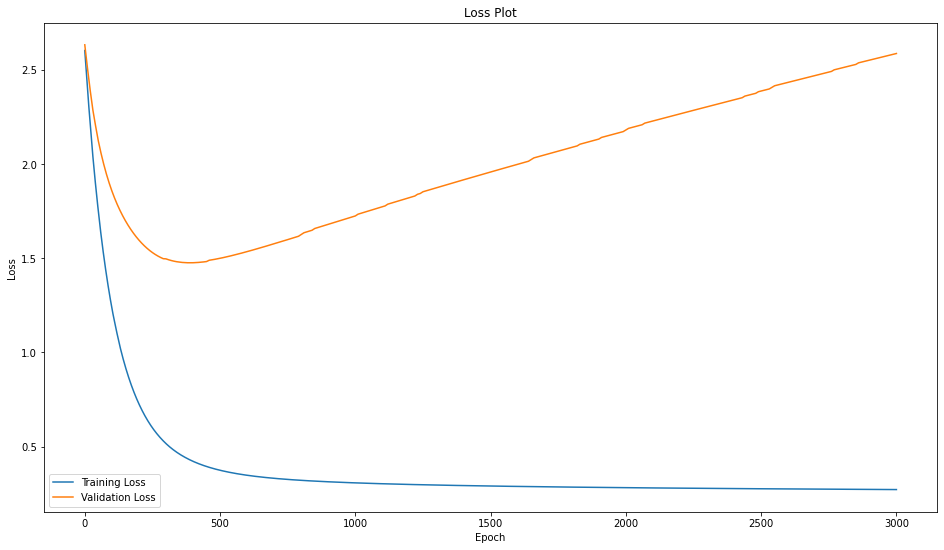

In [111]:
fig = plt.figure(figsize = (16,9))
numOfEpoch = 3001
plt.plot(np.arange(0, numOfEpoch), trainLoss, label='Training Loss')
plt.plot(testEp, testLoss, label='Validation Loss')
plt.title('Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim((0.0,1.0))
plt.legend()

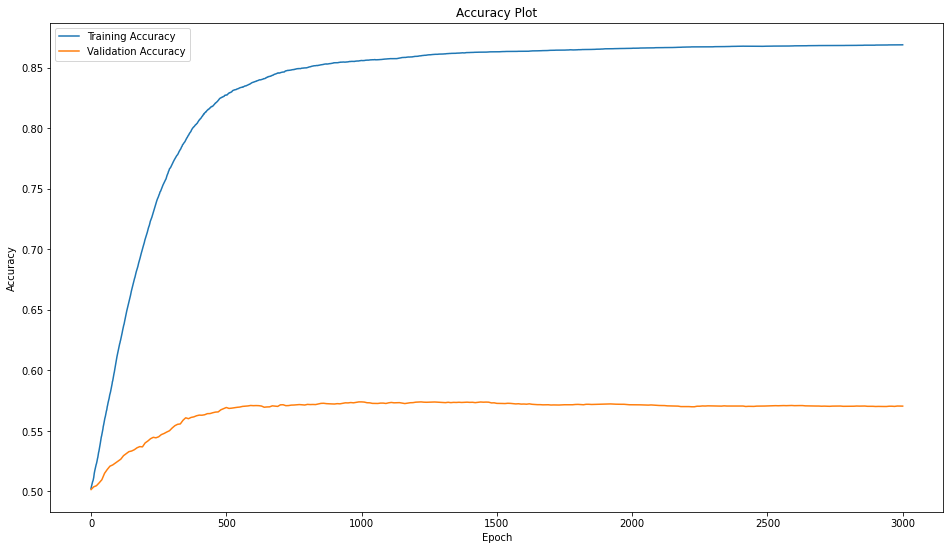

In [112]:
fig = plt.figure(figsize = (16,9))
numOfEpoch = 3001
plt.plot(np.arange(0, numOfEpoch), trainAcc, label='Training Accuracy')
plt.plot(testEp, testAcc, label='Validation Accuracy')
plt.title('Accuracy Plot')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim((0.0,1.0))
plt.legend()

Now apply regularization with lr = 0.005, weight_decay for U is 0.05

In [123]:
U = Variable(torch.randn(len_users, len_features, dtype = torch.float64), requires_grad=True)
b = Variable(torch.randn(len_users, 1, dtype = torch.float64), requires_grad=True)

In [124]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam([U], lr = 0.005, weight_decay = 0.005)
optimizer.add_param_group({'params': b, "lr": 0.005, "weight_decay": 0})

In [125]:
bestU = None
bestb = None
maxAcc = 0.0

In [126]:
EPOCH = 3001
a = Accuracy()
trainLoss = []
testLoss = []
testEp = []
trainAcc = []
testAcc = []
for ep in tqdm(range(EPOCH)):
    optimizer.zero_grad()
    ratings_pred = torch.matmul(torch.cat((U, b), axis = 1), movies_tensor.T)
    mask = ratings_train_tensor.bool()
    nonzero_pred = F.sigmoid(ratings_pred.masked_select(mask))
    nonzero_train = ratings_train_tensor.masked_select(mask)
    nonzero_train = nonzero_train - 1
    loss = criterion(nonzero_pred, nonzero_train.double())
    accuracy = a(nonzero_pred, nonzero_train.int())
    loss.backward()
    optimizer.step()

    trainLoss.append(loss.item())
    trainAcc.append(accuracy.item())
    if ep % 10 == 0:
      mask = ratings_test_tensor.bool()
      nonzero_pred = F.sigmoid(ratings_pred.masked_select(mask))
      nonzero_test = ratings_test_tensor.masked_select(mask)
      nonzero_test = nonzero_test - 1
      loss_test = criterion(nonzero_pred, nonzero_test.double())
      accuracy_test = a(nonzero_pred, nonzero_test.int())

      testEp.append(ep)
      testLoss.append(loss_test.item())
      testAcc.append(accuracy_test.item())
      
      if maxAcc < accuracy_test:
        bestU = U
        bestb = b
        maxAcc = accuracy_test
      print(f'Epoch: {ep}. Train Loss: {loss}. Train Acc: {accuracy}. Valid Loss: {loss_test}. Valid Acc: {accuracy_test}.')


  0%|          | 0/3001 [00:00<?, ?it/s]

Epoch: 0. Train Loss: 2.5365588892146707. Train Acc: 0.504339873790741. Valid Loss: 2.6132164428608564. Valid Acc: 0.48904556035995483.
Epoch: 10. Train Loss: 2.420720174148159. Train Acc: 0.506321132183075. Valid Loss: 2.504036363125874. Valid Acc: 0.49109241366386414.
Epoch: 20. Train Loss: 2.3104521313155346. Train Acc: 0.5078306794166565. Valid Loss: 2.3937070584928817. Valid Acc: 0.49404898285865784.
Epoch: 30. Train Loss: 2.2084279963211224. Train Acc: 0.5098119378089905. Valid Loss: 2.2926539685424494. Valid Acc: 0.49412477016448975.
Epoch: 40. Train Loss: 2.1112848578673997. Train Acc: 0.5109755396842957. Valid Loss: 2.196934712261897. Valid Acc: 0.49708133935928345.
Epoch: 50. Train Loss: 2.021052792102341. Train Acc: 0.5138688087463379. Valid Loss: 2.1065820819387726. Valid Acc: 0.49874913692474365.
Epoch: 60. Train Loss: 1.9334014821358174. Train Acc: 0.5163532495498657. Valid Loss: 2.021249450996734. Valid Acc: 0.5008717775344849.
Epoch: 70. Train Loss: 1.8541347767687952. 

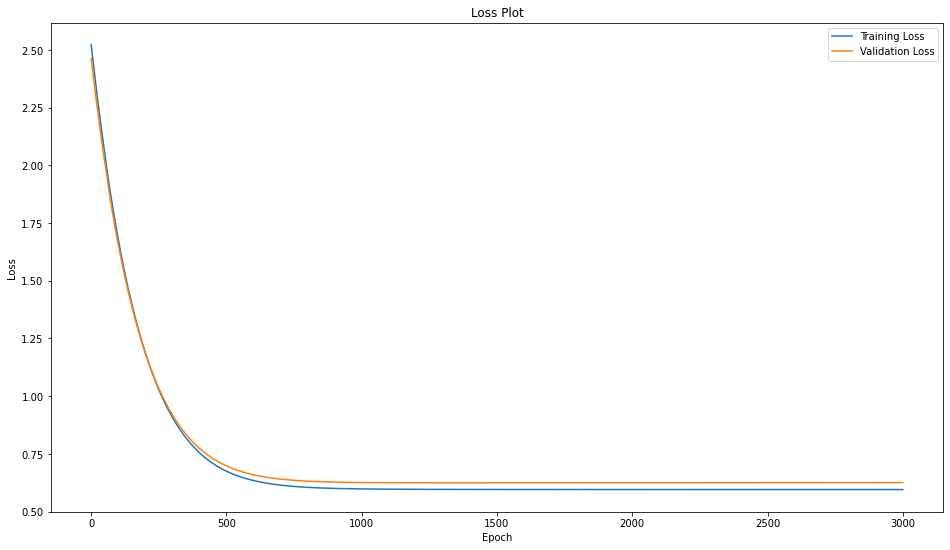

In [117]:
fig = plt.figure(figsize = (16,9))
numOfEpoch = 3001
plt.plot(np.arange(0, numOfEpoch), trainLoss, label='Training Loss')
plt.plot(testEp, testLoss, label='Validation Loss')
plt.title('Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim((0.0,1.0))
plt.legend()

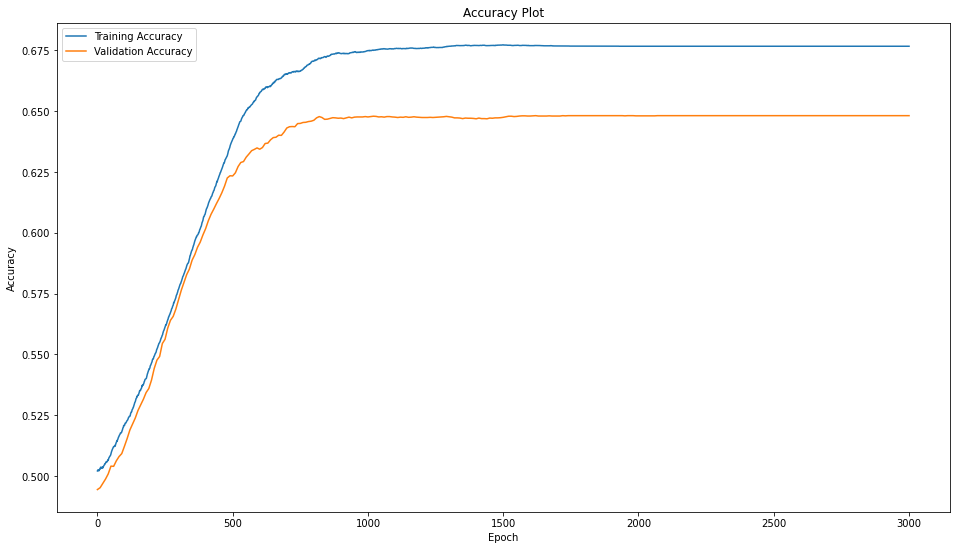

In [118]:
fig = plt.figure(figsize = (16,9))
numOfEpoch = 3001
plt.plot(np.arange(0, numOfEpoch), trainAcc, label='Training Accuracy')
plt.plot(testEp, testAcc, label='Validation Accuracy')
plt.title('Accuracy Plot')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim((0.0,1.0))
plt.legend()

Max Acc on Validation Test

In [127]:
maxAcc

tensor(0.6483)

In [120]:
bestU

tensor([[ 8.5520e-05, -3.2250e-04,  8.9201e-04,  ...,  6.2324e-19,
          1.7898e-19,  1.5869e-19],
        [ 9.5169e-04, -2.9078e-03,  3.0833e-03,  ..., -1.2146e-04,
          2.0347e-03,  3.6578e-19],
        [ 2.2283e-03, -7.5406e-04,  6.2048e-04,  ...,  9.6439e-04,
         -1.2203e-03, -2.0789e-14],
        ...,
        [ 9.1636e-04,  6.7088e-04,  4.7628e-04,  ...,  7.3449e-04,
         -7.2701e-16, -6.1870e-16],
        [ 8.6555e-04, -9.4905e-04,  1.0243e-03,  ...,  7.3378e-04,
         -3.3989e-09, -2.7798e-09],
        [ 1.1846e-05, -1.2608e-03, -3.0960e-04,  ...,  1.4316e-04,
         -2.7402e-03, -2.7624e-03]], dtype=torch.float64, requires_grad=True)

In [121]:
bestU.detach().numpy().tofile("ModelStorage/U.txt")
bestb.detach().numpy().tofile("ModelStorage/b.txt")

In [122]:
with open("ModelStorage/indexToId.txt", "w+") as file:
  file.write(str(indexToId))
with open("ModelStorage/idToIndex.txt", "w+") as file:
  file.write(str(idToIndex))